In [357]:
from wmi_backend_2 import *
from wmi_decompositions import *

import numpy as np

from qiskit import *
from qiskit.circuit.library import XXPlusYYGate
from qiskit.transpiler import Layout
from qiskit.quantum_info.operators import Operator

from qiskit.visualization import *
from util import *

### 2D Trotter

In [358]:
qc_fsim = QuantumCircuit(2)
op_fsim = Operator([
    [1, 0, 0, 0],
    [0, np.cos(4), 1j*np.sin(4), 0],
    [0, 1j*np.sin(4), np.cos(4), 0],
    [0, 0, 0, 1]
])
qc_fsim.unitary(op_fsim, [0, 1], label='fsim')
fSIM = qc_fsim.to_gate(label="FSIM")

In [359]:
qc_fswap = QuantumCircuit(2)
op_fswap = Operator([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, -1]
])
qc_fswap.unitary(op_fswap, [0, 1], label='fswap')
fSWAP = qc_fswap.to_gate(label="FSWAP")

In [360]:
lattice_size = (2,2)
Nx, Ny = lattice_size
num_sites = Nx*Ny

In [361]:
#spin_up = QuantumRegister(num_sites, '↑')
#spin_down = QuantumRegister(num_sites, '↓')
#aux = QuantumRegister(1, "aux")
#circuit = QuantumCircuit(aux, spin_up, spin_down)

spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
aux = QuantumRegister(1, "aux")
circuit = QuantumCircuit(spin_up, spin_down)

In [362]:
u = 1
t = 1
delta_t = 1

In [363]:
# onsite interaction
lam = -u*delta_t
for i in range(num_sites):
    circuit.cp(lam, spin_up[i], spin_down[i])


circuit.barrier(spin_up, spin_down)


theta = -2*t
beta = 0
hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
for hop in hoppings:
    #circuit.append(XXPlusYYGate(theta, beta), hop)
    gate1, gate2 = hop
    circuit.append(fSIM, [gate1, gate2])

circuit.barrier(spin_up, spin_down)

swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
for swap in swaps:
    gate1, gate2 = swap
    #circuit.iswap(gate1, gate2)
    circuit.append(fSWAP, [gate1, gate2])


circuit.barrier(spin_up, spin_down)

theta = -2*t
beta = 0
hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
for hop in hoppings:
    #circuit.append(XXPlusYYGate(theta, beta), hop)
    gate1, gate2 = hop
    circuit.append(fSIM, [gate1, gate2])

circuit.barrier(spin_up, spin_down)

# swap back
swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
for swap in swaps:
    gate1, gate2 = swap
    #circuit.iswap(gate1, gate2)
    circuit.append(fSWAP, [gate1, gate2])

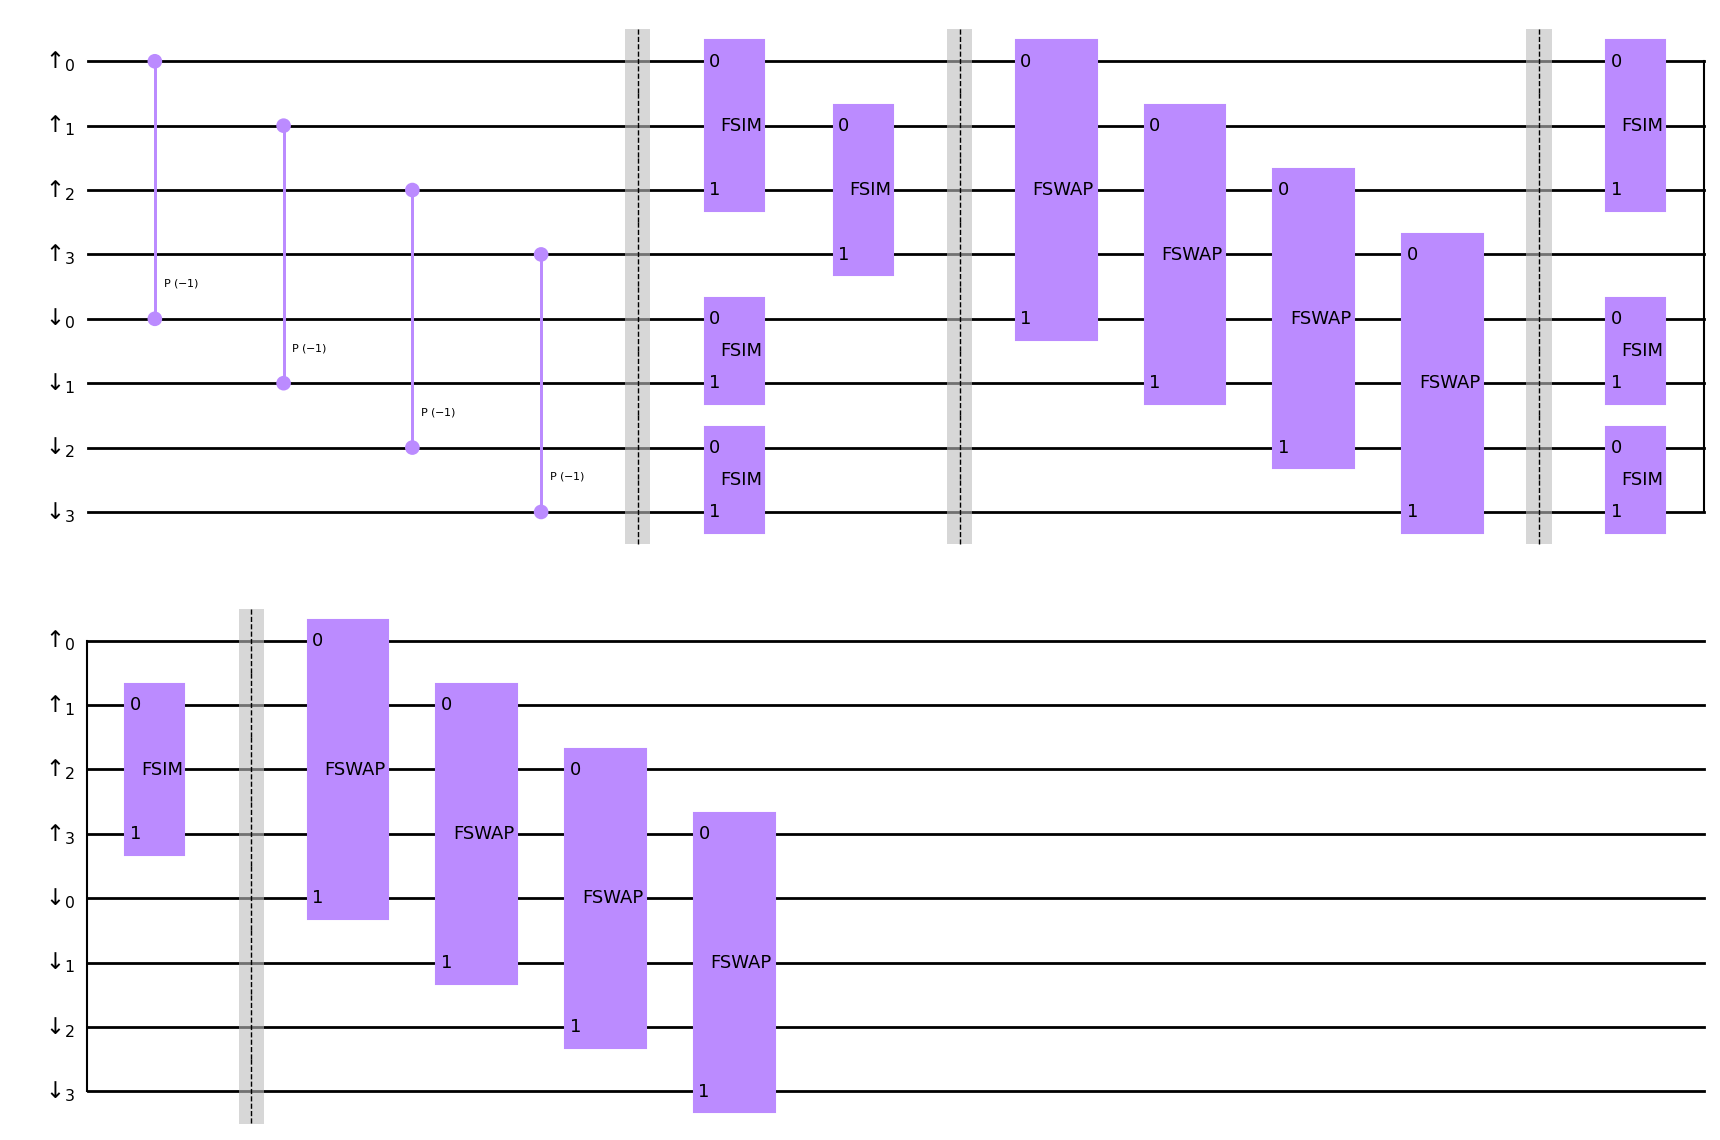

In [364]:
circuit.draw("mpl")

In [365]:
approach = circuit2matrix(circuit, keep_qiskit_ordering=False)

### Reference Hamiltonian

In [349]:
from qiskit.opflow import X, Y, Z, I, PauliTrotterEvolution, PauliSumOp
from qiskit.circuit import Parameter

# 1↑ 2↑ 3↑ 4↑ 1↓ 2↓ 3↓ 4↓


# interaction term
A = 1/2*(I-Z)
H1 = (A^I^I^I^A^I^I^I) + (I^A^I^I^I^A^I^I) + (I^I^A^I^I^I^A^I) + (I^I^I^A^I^I^I^A)

# hopping term
H2 = -2*t*(
            (X^I^X^I^I^I^I^I) + (Y^I^Y^I^I^I^I^I)
            +(I^X^I^X^I^I^I^I) + (I^Y^I^Y^I^I^I^I)
            +(I^I^I^I^X^X^I^I) + (I^I^I^I^Y^Y^I^I)
            +(I^I^I^I^I^I^X^X) + (I^I^I^I^I^I^Y^Y)

            +(X^X^I^I^Z^Z^I^I) + (Y^Y^I^I^Z^Z^I^I)
            +(I^I^X^X^I^I^Z^Z) + (I^I^Y^Y^I^I^Z^Z)
            +(Z^I^Z^I^X^I^X^I) + (Z^I^Z^I^Y^I^Y^I)
            +(I^Z^I^Z^I^X^I^X) + (I^Z^I^Z^I^Y^I^Y)
            )
hamiltonian = H1 + H2
# evolution operator
evo_time = Parameter('t')
evolution_op = (evo_time*hamiltonian).exp_i()
print(evolution_op)
# into circuit
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
                    trotter_mode='trotter',
                    reps=num_time_slices).convert(evolution_op)
#trotterized_op.to_circuit().draw('mpl')

e^(-i*t * (
  0.25 * IIIIIIII
  - 0.25 * IIIIZIII
  - 0.25 * ZIIIIIII
  + 0.25 * ZIIIZIII
  + 0.25 * IIIIIIII
  - 0.25 * IIIIIZII
  - 0.25 * IZIIIIII
  + 0.25 * IZIIIZII
  + 0.25 * IIIIIIII
  - 0.25 * IIIIIIZI
  - 0.25 * IIZIIIII
  + 0.25 * IIZIIIZI
  + 0.25 * IIIIIIII
  - 0.25 * IIIIIIIZ
  - 0.25 * IIIZIIII
  + 0.25 * IIIZIIIZ
  - 2.0 * XIXIIIII
  - 2.0 * YIYIIIII
  - 2.0 * IXIXIIII
  - 2.0 * IYIYIIII
  - 2.0 * IIIIXXII
  - 2.0 * IIIIYYII
  - 2.0 * IIIIIIXX
  - 2.0 * IIIIIIYY
  - 2.0 * XXIIZZII
  - 2.0 * YYIIZZII
  - 2.0 * IIXXIIZZ
  - 2.0 * IIYYIIZZ
  - 2.0 * ZIZIXIXI
  - 2.0 * ZIZIYIYI
  - 2.0 * IZIZIXIX
  - 2.0 * IZIZIYIY
))


C:\Users\thilo\AppData\Local\Temp\ipykernel_30912\3635892576.py:30: DeprecationWarning: The class ``qiskit.opflow.evolutions.pauli_trotter_evolution.PauliTrotterEvolution`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  trotterized_op = PauliTrotterEvolution(


In [350]:
circuit = trotterized_op.to_circuit()
param_bind = {
    evo_time: 1,
}
ref_circ = trotterized_op.bind_parameters(param_bind).eval().to_circuit_op().to_circuit()
ref_matrix = trotterized_op.bind_parameters(param_bind).eval().to_matrix()

In [351]:
print("Error: " + str(np.linalg.norm(ref_matrix - approach, 2)))

Error: 3.947314014662047e-15


### Mapping

In [366]:
backend = Mybackend()

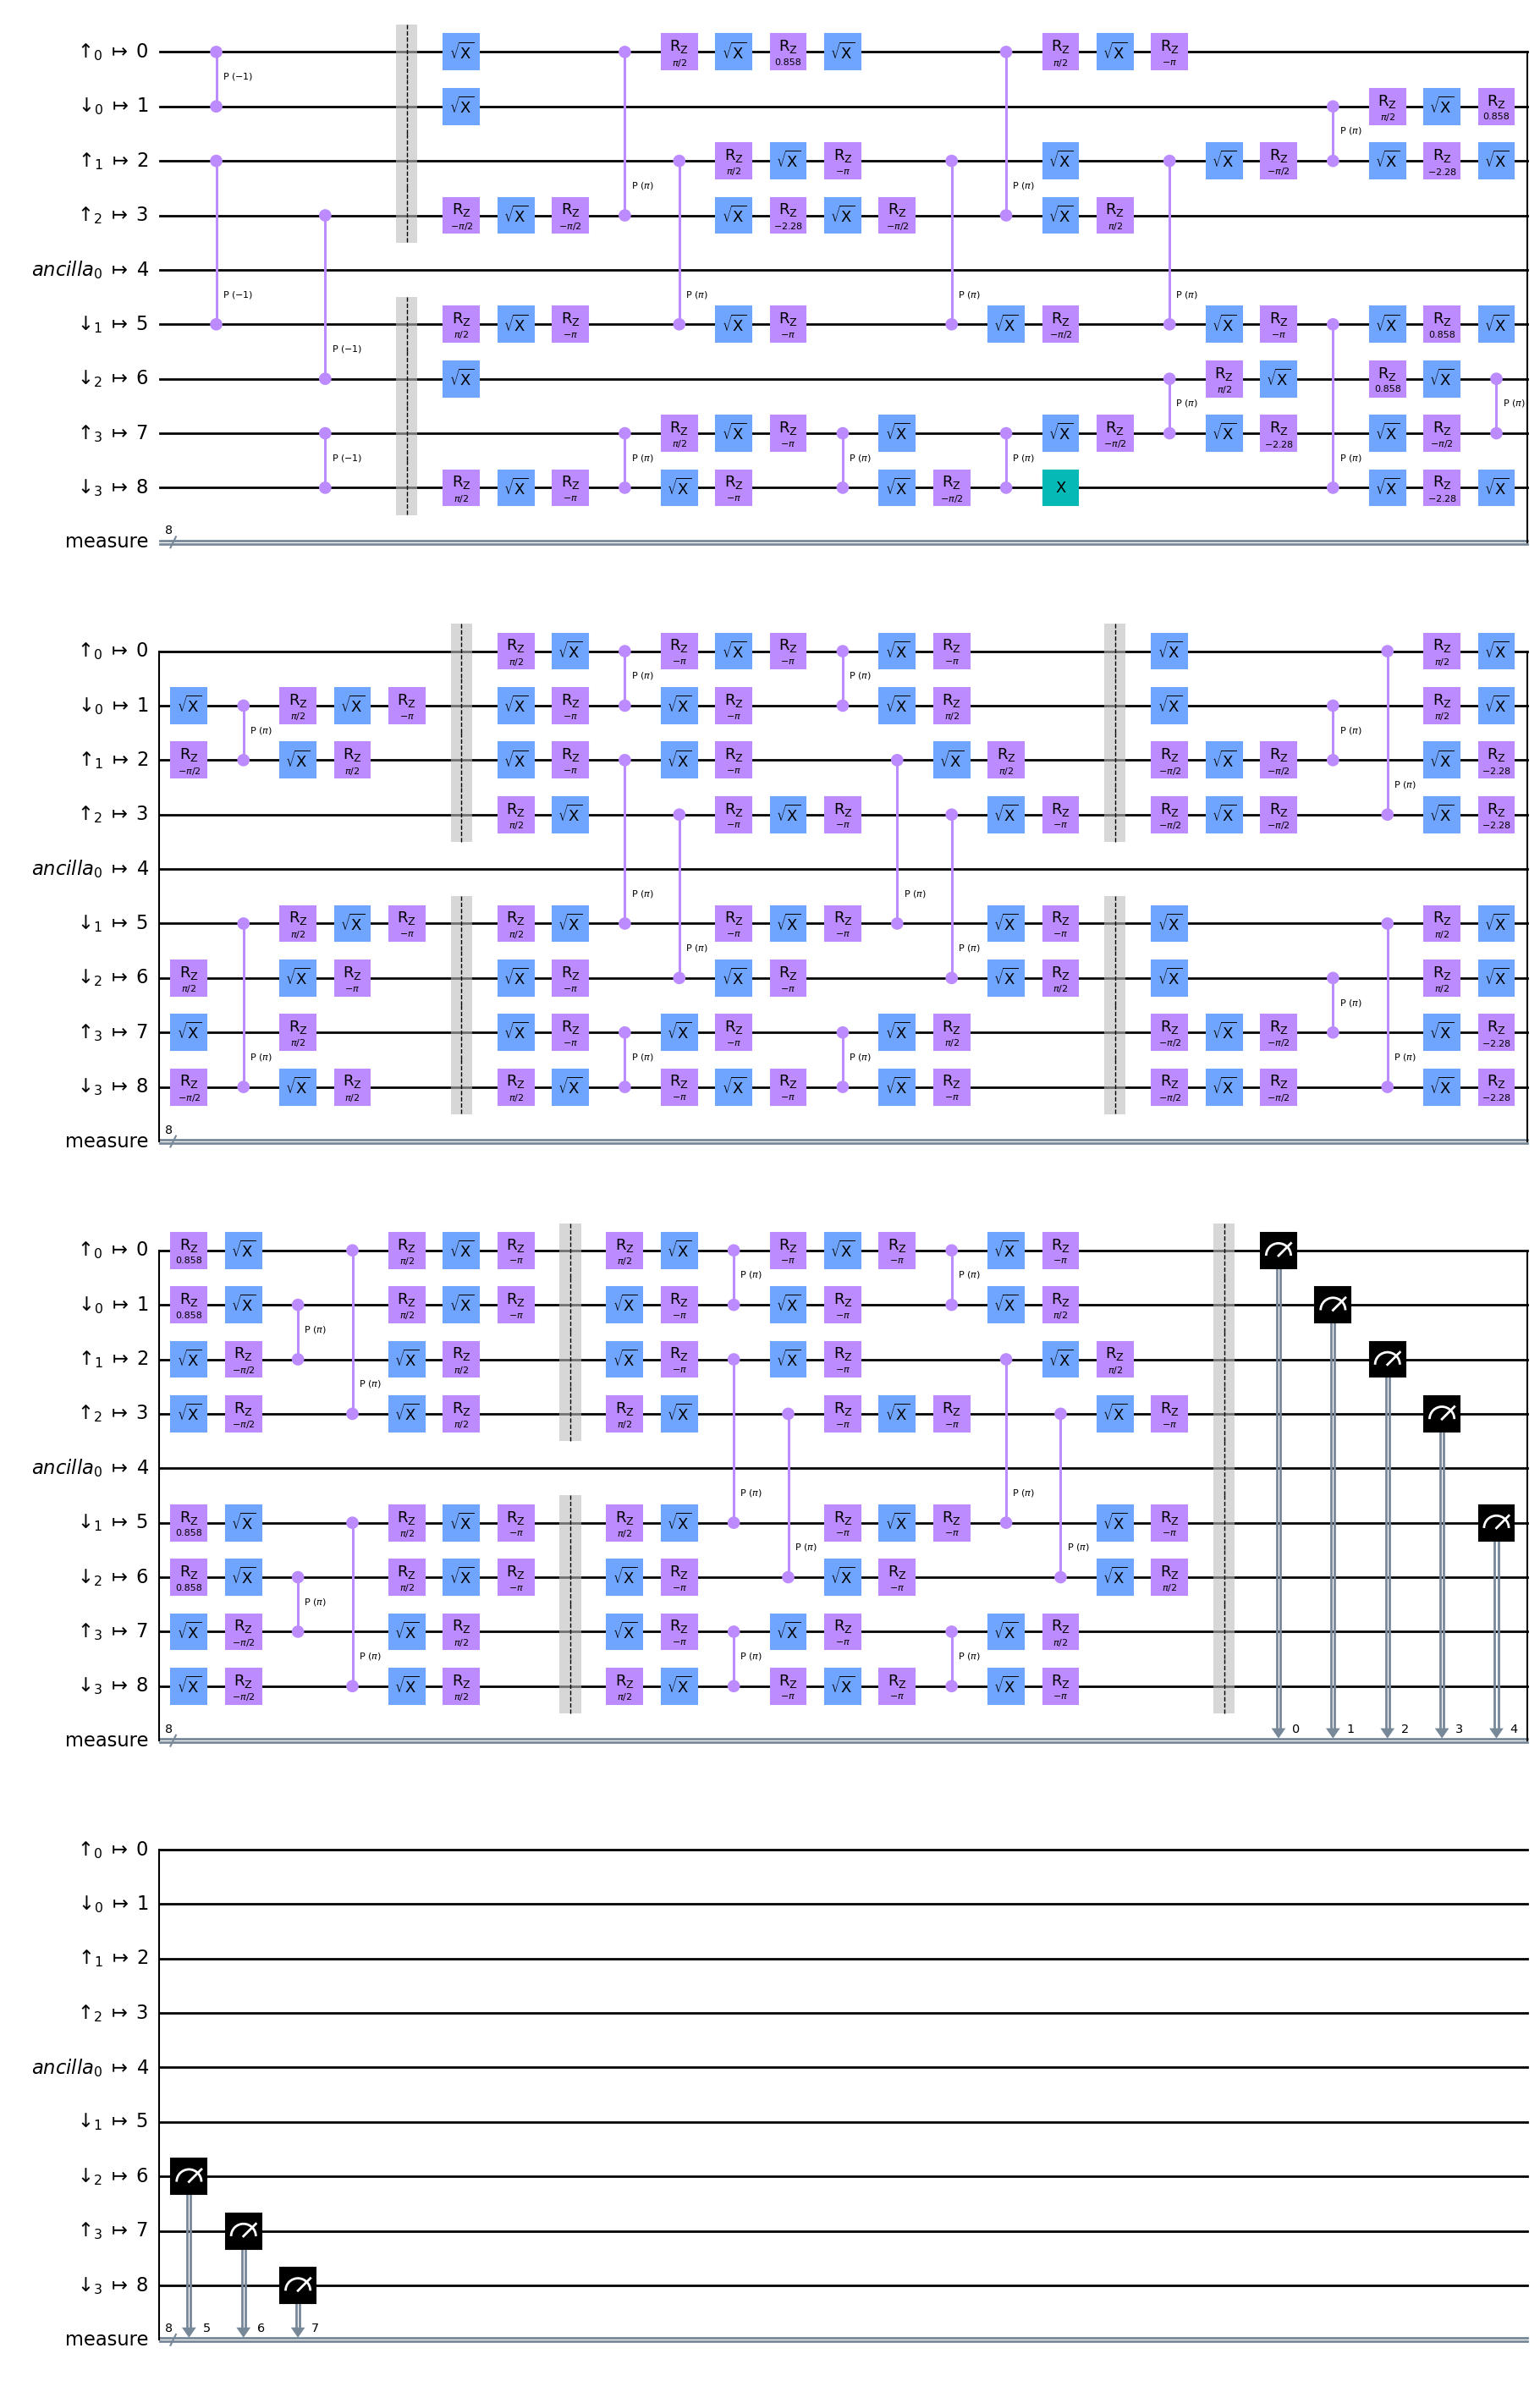

In [367]:
initial_layout = Layout({
    spin_up[0]:   0,
    spin_down[0]: 1,
    spin_up[1]:   2,
    spin_down[1]: 5,
    spin_up[2]:   3,
    spin_down[2]: 6,
    spin_up[3]:   7,
    spin_down[3]: 8,
})

# Transpile to WMI hardware
test_circ = transpile(
    circuit,
    backend=backend,
    optimization_level=3,
    initial_layout=initial_layout
)
test_circ.measure_active()
test_circ.draw("mpl")